1. Training set
    - Traing images are original and without "heavy" image processing
    - Imbalanced distribution
    - **Traditional features** from images
        - Local features : SIFT - kmeans (1024) + HOG - PCA (1100)
        - Texture features: Gabor (96) + LBPH (700)
2. 
    - Use MLP layer for image features: Dense, Batchnorm, Activation Relu, Dropout 0.5


In [1]:
import os
import time
import datetime

from pathlib import Path
import pandas as pd

import tensorflow as tf
print("TensorFlow successfully installed.")
if tf.test.is_built_with_cuda():
    print("The installed version of TensorFlow includes GPU support.")
    print("tensorflow - current version:", tf.__version__)
    print("tensorflow - physical device:", tf.config.list_physical_devices())
else:
    print("The installed version of TensorFlow does not include GPU support.")
    
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)


import tensorflow_addons as tfa

import tensorflow.keras as keras
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

from tensorflow.keras.callbacks import Callback, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import Model 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras import mixed_precision
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input, LeakyReLU,ReLU
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization , Input ,concatenate
from tensorflow.keras.regularizers import l1,l2, l1_l2
from tensorflow.keras.models import model_from_json
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from collections import Counter
from collections import OrderedDict
from itertools import cycle

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve,  roc_curve, auc, f1_score



import math
import matplotlib.pyplot as plt
from matplotlib import pyplot

import matplotlib.patches as mpatches

from PIL import Image

import random
import numpy as np
from numpy import where

import scipy.stats as stats

import sys
import importlib.util

import math
import time

from tqdm.notebook import tqdm

import gc


2023-06-27 17:35:40.258125: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-27 17:35:40.308082: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-27 17:35:40.973834: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


TensorFlow successfully installed.
The installed version of TensorFlow includes GPU support.
tensorflow - current version: 2.12.0
tensorflow - physical device: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


/home/centuri-mep-01/anaconda3/envs/tf212/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# 2. Load image features (i.e., SIFT + k-means with k=1024)

During the feature extraction, i observed the same distribution of number of clusters. THan i support the MLP will be the same for all folds

In [2]:
# SIFT + k-means (k=1024) 

filepath_features_train = f"..//_inputs//_image_features//new3//X-SIFT_1024_std-train-fold_1.csv"

filepath_features_validation = f"..//_inputs//_image_features//new3//X-SIFT_1024_std-validation-fold_1.csv"

# filepath_features_test = f"..//_inputs//_image_features//new3//X-SIFT_1024_std-test-fold_1.csv"

X_SIFT_train_df = pd.read_csv(filepath_features_train, header=None)
X_SIFT_validation_df = pd.read_csv(filepath_features_validation, header=None)
# X_SIFT_test_df = pd.read_csv(filepath_features_test, header=None)

display(X_SIFT_train_df.head(5))
display(X_SIFT_train_df.shape)
display(X_SIFT_validation_df.head(5))
display(X_SIFT_validation_df.shape)
# display(X_SIFT_test_df.head(5))
# display(X_SIFT_test_df.shape)

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024
0,0001-aggregates.png,-0.201468,-0.120201,-0.265277,1.345567,1.404456,-0.223910,-0.153469,-0.299044,0.760385,...,-0.13818,-0.158957,-0.164388,-0.11576,-0.205646,-0.155519,-0.188667,5.407507,-0.153162,-0.131382
1,0002.png,-0.201468,-0.120201,-0.265277,-0.103267,-0.106819,-0.223910,-0.153469,-0.413064,-0.107453,...,-0.13818,11.354668,10.571298,-0.11576,-0.205646,-0.155519,-0.188667,-0.108232,-0.153162,-0.131382
2,0003-aggregates.png,-0.201468,-0.120201,-0.265277,-0.103267,-0.106819,0.538241,-0.153469,-0.413064,-0.107453,...,-0.13818,-0.158957,-0.164388,-0.11576,-0.205646,-0.155519,-0.188667,-0.108232,-0.153162,-0.131382
3,0004-aggregates.png,-0.201468,-0.120201,-0.265277,-0.103267,-0.106819,-0.223910,-0.153469,1.753329,-0.107453,...,-0.13818,-0.158957,-0.164388,-0.11576,-0.205646,-0.155519,-0.188667,-0.108232,-0.153162,-0.131382
4,0004.png,-0.201468,5.596114,-0.265277,-0.103267,-0.106819,-0.223910,-0.153469,-0.413064,-0.107453,...,-0.13818,-0.158957,-0.164388,-0.11576,-0.205646,-0.155519,-0.188667,-0.108232,-0.153162,-0.131382


(44099, 1025)

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024
0,0002-aggregates.png,-0.201468,-0.120201,-0.265277,-0.103267,-0.106819,-0.223910,-0.153469,-0.413064,-0.107453,...,-0.13818,-0.158957,-0.164388,-0.11576,-0.205646,-0.155519,-0.188667,-0.108232,-0.153162,-0.131382
1,0006-aggregates.png,-0.201468,-0.120201,-0.265277,-0.103267,-0.106819,-0.223910,-0.153469,-0.413064,-0.107453,...,-0.13818,-0.158957,-0.164388,-0.11576,-0.205646,4.137915,-0.188667,-0.108232,-0.153162,-0.131382
2,001-aggregates-jo_700_05.png,-0.201468,-0.120201,-0.265277,-0.103267,-0.106819,-0.223910,-0.153469,-0.413064,-0.107453,...,-0.13818,-0.158957,-0.164388,-0.11576,-0.205646,-0.155519,-0.188667,-0.108232,-0.153162,2.317457
3,0010-aggregates.png,-0.201468,-0.120201,-0.265277,-0.103267,-0.106819,0.735584,-0.153469,-0.413064,-0.107453,...,-0.13818,-0.158957,-0.164388,-0.11576,-0.205646,-0.155519,-0.188667,-0.108232,-0.153162,-0.131382
4,0011.png,-0.201468,-0.120201,-0.265277,-0.103267,-0.106819,-0.223910,-0.153469,-0.413064,-0.107453,...,-0.13818,-0.158957,-0.164388,-0.11576,-0.205646,-0.155519,-0.188667,-0.108232,-0.153162,-0.131382


(14700, 1025)

In [3]:
# HOG + PCA (1100) 

filepath_features_train = f"..//_inputs//_image_features//new3//X-HOG_std_PCA_1100_std-train-fold_1.csv"

filepath_features_validation = f"..//_inputs//_image_features//new3//X-HOG_std_PCA_1100_std-validation-fold_1.csv"

# filepath_features_test = f"..//_inputs//_image_features//new3//X-HOG_std_PCA_1100_std-test-fold_1.csv"

X_HOGPCA_train_df = pd.read_csv(filepath_features_train, header=None)
X_HOGPCA_validation_df = pd.read_csv(filepath_features_validation, header=None)
# X_HOGPCA_test_df = pd.read_csv(filepath_features_test, header=None)

display(X_HOGPCA_train_df.head(5))
display(X_HOGPCA_train_df.shape)
display(X_HOGPCA_validation_df.head(5))
display(X_HOGPCA_validation_df.shape)
# display(X_HOGPCA_test_df.head(5))
# display(X_HOGPCA_test_df.shape)

,0,1,2,3,4,5,6,7,8,9,...,1091,1092,1093,1094,1095,1096,1097,1098,1099,1100
0,0001-aggregates.png,0.917148,1.447246,0.206029,-1.107510,-1.734309,0.399973,0.329698,-0.708391,-0.284369,...,0.511516,1.532829,-0.091285,1.621535,-0.197880,0.682659,-0.838745,-0.156916,1.951763,-0.464003
1,0002.png,0.370505,-0.948531,0.756832,-0.493438,1.041628,-1.255949,-0.119693,-1.534237,-0.714659,...,-0.079446,-0.215757,1.081805,-0.632592,-1.280335,0.687809,-0.206522,1.736197,-0.415600,0.495210
2,0003-aggregates.png,2.865255,1.593701,0.678115,1.457410,-0.285363,-2.661964,-0.595322,1.991623,-1.164248,...,1.624138,1.999911,-0.900000,0.503939,-2.237205,-1.134731,0.243765,0.064901,0.600189,-1.111427
3,0004-aggregates.png,-1.317980,1.106058,-0.475207,0.014288,-0.773317,1.132120,0.918911,-1.054879,-1.039779,...,-0.454460,0.244967,-0.360653,1.493211,0.256294,-0.670891,-0.415434,-0.104941,0.209982,0.116195
4,0004.png,0.805215,-0.247367,1.353335,1.581153,-1.279883,-0.339334,-0.500247,-1.551780,-1.650041,...,-1.769747,0.593067,0.236974,-2.268845,1.587752,1.290187,-0.017582,0.530560,1.899955,-0.968483


(44099, 1101)

,0,1,2,3,4,5,6,7,8,9,...,1091,1092,1093,1094,1095,1096,1097,1098,1099,1100
0,0002-aggregates.png,-0.005962,0.047701,1.075164,-0.732217,-1.554549,0.148789,0.036890,0.857929,0.348601,...,1.376050,1.263499,0.995447,0.685557,-0.099480,-0.603319,-0.834841,1.428551,1.778422,1.221029
1,0006-aggregates.png,0.301887,-0.205501,0.333048,-0.741293,-0.972635,-0.357926,1.407182,-1.916246,0.145617,...,-0.441662,0.431345,1.046982,-0.620637,0.403026,-0.219844,-0.271041,-0.115279,-1.132150,0.786428
2,001-aggregates-jo_700_05.png,2.366545,0.749287,0.652475,-1.861808,-0.702044,-0.365452,0.328857,0.476454,0.367040,...,0.731662,3.773888,-0.604871,-0.923889,0.416154,-1.340859,0.559198,-0.620273,0.453902,-0.172933
3,0010-aggregates.png,-0.160033,0.347112,-0.668117,-0.461242,-0.508690,1.609127,-0.454135,-1.161684,-0.853908,...,0.444387,0.432414,-0.665007,-0.123202,-0.987345,-0.099243,-1.443244,1.550003,0.090061,0.305470
4,0011.png,0.012900,-0.917647,-1.639604,0.979652,-0.571192,0.432666,0.224566,2.290114,0.181760,...,0.061558,-0.936495,0.084808,1.413953,-0.674965,-1.838460,0.212193,-0.265324,-0.616324,0.788030


(14700, 1101)

In [4]:
# LBPH + PCA (k=700) 

filepath_features_train = f"..//_inputs//_image_features//new3//X-LBPH_std_PCA_700_std-train-fold_1.csv"

filepath_features_validation = f"..//_inputs//_image_features//new3//X-LBPH_std_PCA_700_std-validation-fold_1.csv"

# filepath_features_test = f"..//_inputs//_image_features//new3//X-LBPH_std_PCA_700_std-test-fold_1.csv"

X_LBPPCA_train_df = pd.read_csv(filepath_features_train, header=None)
X_LBPPCA_validation_df = pd.read_csv(filepath_features_validation, header=None)
# X_LBPPCA_test_df = pd.read_csv(filepath_features_test, header=None)

display(X_LBPPCA_train_df.head(5))
display(X_LBPPCA_train_df.shape)
display(X_LBPPCA_validation_df.head(5))
display(X_LBPPCA_validation_df.shape)
# display(X_LBPPCA_test_df.head(5))
# display(X_LBPPCA_test_df.shape)

,0,1,2,3,4,5,6,7,8,9,...,691,692,693,694,695,696,697,698,699,700
0,0001-aggregates.png,0.308727,1.316579,0.630467,3.418796,-2.693078,-3.238267,-0.590420,0.019234,-0.351118,...,-0.637837,-0.265665,0.625102,0.406829,0.974950,-0.137263,-0.688936,0.322928,0.274049,0.385426
1,0002.png,0.361147,0.571496,-0.685116,-1.160239,-0.395774,0.111746,-0.726038,0.229202,-1.454250,...,-0.477845,1.402088,-0.269257,-0.221349,-0.234698,2.023317,0.132266,0.596958,-0.340160,0.542286
2,0003-aggregates.png,0.980396,2.599591,0.603540,4.313452,-1.132047,1.763776,0.476505,-3.155756,0.737257,...,0.252886,-0.123262,0.024477,-0.496797,0.751898,2.025890,-0.115334,-1.173961,-2.982374,-1.454144
3,0004-aggregates.png,-0.069817,-1.562222,0.938040,-0.464418,0.039651,0.132615,0.359263,0.169221,-1.172523,...,0.896005,0.459168,0.046755,0.059574,0.314382,-1.254721,-0.171246,0.006423,-0.762859,1.357159
4,0004.png,-0.402581,0.788254,-1.085370,0.432337,-1.206545,0.037245,0.243501,-0.140822,-1.117797,...,0.681932,-0.537194,-1.186791,-1.369011,-0.281544,0.047441,1.273257,0.488321,-0.059476,0.358138


(44099, 701)

,0,1,2,3,4,5,6,7,8,9,...,691,692,693,694,695,696,697,698,699,700
0,0002-aggregates.png,0.765992,-0.796624,-1.360983,-0.374998,-0.618884,0.208406,1.258762,0.400807,1.834416,...,0.520593,0.216804,5.766702,0.438995,-1.818535,-1.288561,1.216192,-0.018690,-2.220765,1.836242
1,0006-aggregates.png,-0.325505,0.006659,-0.379714,-0.312947,-0.648610,-0.666377,0.428429,0.285496,-0.672031,...,-0.511078,0.134863,-0.178913,-0.092466,-0.350086,-0.673897,0.604665,-0.620063,0.169654,-0.531466
2,001-aggregates-jo_700_05.png,2.145377,1.744753,0.074425,0.931798,0.870122,-1.400807,-0.645181,1.197517,1.272663,...,-2.214210,-0.196517,-0.527347,2.954624,-2.770604,-0.738247,-0.475386,-1.203956,0.853601,1.157176
3,0010-aggregates.png,-0.624999,-0.309189,0.646886,0.403913,-0.228607,-0.708147,0.350358,0.319969,-1.268609,...,0.292169,0.242131,-0.143010,-0.418193,0.144117,0.249611,-0.087513,0.891432,-0.427881,0.152774
4,0011.png,-0.772932,1.024333,0.893706,-0.540567,-0.375237,0.139439,-0.139803,-0.224778,1.239717,...,0.470533,0.932145,-0.219935,0.201913,0.247203,-0.175417,1.181583,-0.144998,0.481421,-0.387397


(14700, 701)

In [5]:
# Gabor filters (96)

filepath_features_train = f"..//_inputs//_image_features//new3//X-gabor_96_std-train-fold_1.csv"

filepath_features_validation = f"..//_inputs//_image_features//new3//X-gabor_96_std-validation-fold_1.csv"

# filepath_features_test = f"..//_inputs//_image_features//new3//X-gabor_96_std-test-fold_1.csv"

X_gabor_train_df = pd.read_csv(filepath_features_train, header=None)
X_gabor_validation_df = pd.read_csv(filepath_features_validation, header=None)
# X_gabor_test_df = pd.read_csv(filepath_features_test, header=None)

display(X_gabor_train_df.head(5))
display(X_gabor_train_df.shape)
display(X_gabor_validation_df.head(5))
display(X_gabor_validation_df.shape)
# display(X_gabor_test_df.head(5))
# display(X_gabor_test_df.shape)

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,96
0,0001-aggregates.png,1.136312,-0.120867,1.151158,-0.114632,1.209658,0.191188,1.300448,0.745374,1.352405,...,-0.742402,-1.194496,-0.721887,-1.174843,-0.721007,-1.183975,-0.732128,-1.221598,-0.744075,-1.200731
1,0002.png,0.232402,-0.388770,0.245820,-0.432895,0.242654,-0.452550,0.217668,-0.430446,0.192616,...,0.220550,-0.009426,-0.510338,-0.274120,-0.623958,-0.310437,-0.607235,-0.319016,-0.582036,-0.387699
2,0003-aggregates.png,1.147477,0.747343,1.118156,0.435737,1.116818,0.321630,1.195342,0.754692,1.287895,...,-0.756436,-0.912781,-0.721888,-0.821082,-0.754551,-0.978059,-0.771848,-1.065330,-0.774409,-1.017040
3,0004-aggregates.png,-0.492552,0.765120,-0.528705,0.749952,-0.585569,0.758288,-0.627541,0.739659,-0.632524,...,-1.101012,-0.334478,-1.115239,-0.354489,-0.666226,-0.337154,1.038831,0.430920,2.542540,2.356331
4,0004.png,0.659027,-0.766207,0.697820,-0.732164,0.744554,-0.687640,0.749926,-0.640430,0.692348,...,0.158381,-0.283880,-0.428167,-0.801556,-0.787669,-0.932667,-0.801749,-0.928621,-0.763943,-0.889699


(44099, 97)

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,96
0,0002-aggregates.png,-1.124807,0.846440,-1.138088,0.866766,-1.149040,0.865567,-1.170127,0.882358,-1.165774,...,-0.018641,0.365488,0.462320,0.610102,0.639254,0.854176,0.087541,0.243078,0.794500,0.856870
1,0006-aggregates.png,0.583940,-0.551095,0.573031,-0.542108,0.564279,-0.574851,0.556822,-0.644346,0.564660,...,-0.534824,-0.458842,-0.467645,-0.587663,-0.184629,-0.352692,0.289746,0.295499,0.325833,0.408612
2,001-aggregates-jo_700_05.png,-0.452301,0.901055,-0.440633,0.929559,-0.418416,0.959422,-0.391965,0.993847,-0.382175,...,0.383506,1.067756,0.131348,0.300736,-0.340842,0.092228,-0.424322,0.215652,-0.450190,0.159132
3,0010-aggregates.png,0.553547,-0.551249,0.559949,-0.522796,0.566758,-0.474370,0.565353,-0.468133,0.551870,...,-0.208128,-0.346751,-0.063954,-0.113626,-0.114338,-0.329164,-0.289741,-0.405385,-0.460871,-0.544875
4,0011.png,0.878954,-1.234502,0.870033,-1.165677,0.867735,-1.162138,0.873726,-1.118144,0.914043,...,-0.775883,-1.183196,-0.431509,-0.765326,0.178111,-0.425520,-0.282132,-0.658629,-0.743051,-1.142364


(14700, 97)

In [6]:
# merge image features into an unique feature vector for each set

# training set
X_features_train_df = pd.concat([X_SIFT_train_df, 
                                 X_HOGPCA_train_df.loc[:,1:],
                                 X_gabor_train_df.loc[:,1:],
                                 X_LBPPCA_train_df.loc[:,1:]], axis=1)

X_features_train_df.columns = range(len(X_features_train_df.columns))   # reset column indexes    

display(X_features_train_df.head(5))
display(X_features_train_df.shape)   



# validation set
X_features_validation_df = pd.concat([X_SIFT_validation_df, 
                                 X_HOGPCA_validation_df.loc[:,1:],
                                 X_gabor_validation_df.loc[:,1:],
                                 X_LBPPCA_validation_df.loc[:,1:]], axis=1)

X_features_validation_df.columns = range(len(X_features_validation_df.columns))   # reset column indexes   
                                            
display(X_features_validation_df.head(5))
display(X_features_validation_df.shape)  


# # test set
# X_features_test_df = pd.concat([X_SIFT_test_df, 
#                                  X_HOGPCA_test_df.loc[:,1:],
#                                  X_gabor_test_df.loc[:,1:],
#                                  X_LBPPCA_test_df.loc[:,1:]], axis=1)
                                            
# X_features_test_df.columns = range(len(X_features_test_df.columns))   # reset column indexes   

# display(X_features_test_df.head(5))
# display(X_features_test_df.shape)   


,0,1,2,3,4,5,6,7,8,9,...,2911,2912,2913,2914,2915,2916,2917,2918,2919,2920
0,0001-aggregates.png,-0.201468,-0.120201,-0.265277,1.345567,1.404456,-0.223910,-0.153469,-0.299044,0.760385,...,-0.637837,-0.265665,0.625102,0.406829,0.974950,-0.137263,-0.688936,0.322928,0.274049,0.385426
1,0002.png,-0.201468,-0.120201,-0.265277,-0.103267,-0.106819,-0.223910,-0.153469,-0.413064,-0.107453,...,-0.477845,1.402088,-0.269257,-0.221349,-0.234698,2.023317,0.132266,0.596958,-0.340160,0.542286
2,0003-aggregates.png,-0.201468,-0.120201,-0.265277,-0.103267,-0.106819,0.538241,-0.153469,-0.413064,-0.107453,...,0.252886,-0.123262,0.024477,-0.496797,0.751898,2.025890,-0.115334,-1.173961,-2.982374,-1.454144
3,0004-aggregates.png,-0.201468,-0.120201,-0.265277,-0.103267,-0.106819,-0.223910,-0.153469,1.753329,-0.107453,...,0.896005,0.459168,0.046755,0.059574,0.314382,-1.254721,-0.171246,0.006423,-0.762859,1.357159
4,0004.png,-0.201468,5.596114,-0.265277,-0.103267,-0.106819,-0.223910,-0.153469,-0.413064,-0.107453,...,0.681932,-0.537194,-1.186791,-1.369011,-0.281544,0.047441,1.273257,0.488321,-0.059476,0.358138


(44099, 2921)

,0,1,2,3,4,5,6,7,8,9,...,2911,2912,2913,2914,2915,2916,2917,2918,2919,2920
0,0002-aggregates.png,-0.201468,-0.120201,-0.265277,-0.103267,-0.106819,-0.223910,-0.153469,-0.413064,-0.107453,...,0.520593,0.216804,5.766702,0.438995,-1.818535,-1.288561,1.216192,-0.018690,-2.220765,1.836242
1,0006-aggregates.png,-0.201468,-0.120201,-0.265277,-0.103267,-0.106819,-0.223910,-0.153469,-0.413064,-0.107453,...,-0.511078,0.134863,-0.178913,-0.092466,-0.350086,-0.673897,0.604665,-0.620063,0.169654,-0.531466
2,001-aggregates-jo_700_05.png,-0.201468,-0.120201,-0.265277,-0.103267,-0.106819,-0.223910,-0.153469,-0.413064,-0.107453,...,-2.214210,-0.196517,-0.527347,2.954624,-2.770604,-0.738247,-0.475386,-1.203956,0.853601,1.157176
3,0010-aggregates.png,-0.201468,-0.120201,-0.265277,-0.103267,-0.106819,0.735584,-0.153469,-0.413064,-0.107453,...,0.292169,0.242131,-0.143010,-0.418193,0.144117,0.249611,-0.087513,0.891432,-0.427881,0.152774
4,0011.png,-0.201468,-0.120201,-0.265277,-0.103267,-0.106819,-0.223910,-0.153469,-0.413064,-0.107453,...,0.470533,0.932145,-0.219935,0.201913,0.247203,-0.175417,1.181583,-0.144998,0.481421,-0.387397


(14700, 2921)

# 2. Load train, validation and test sets from **original images** of fold 1

In [7]:
filepath_train = f"..//_inputs//_images_Zooscan//_Zooscan-training-fold_1.csv"
print(filepath_train)

filepath_validation = f"..//_inputs//_images_Zooscan//_Zooscan-validation-fold_1.csv"
print(filepath_validation)

filepath_test = f"..//_inputs//_images_Zooscan//ZooScan-test_img.csv"
print(filepath_test)

..//_inputs//_images_Zooscan//_Zooscan-training-fold_1.csv
..//_inputs//_images_Zooscan//_Zooscan-validation-fold_1.csv
..//_inputs//_images_Zooscan//ZooScan-test_img.csv


In [8]:
X_train_df = pd.read_csv(filepath_train)
X_validation_df = pd.read_csv(filepath_validation)
# X_test_df = pd.read_csv(filepath_test)

In [9]:
display(X_train_df.head(5), X_train_df.shape)
display(X_validation_df.head(5), X_validation_df.shape)
# display(X_test_df.head(5), X_test_df.shape)

,filenames,labels,short_filenames,cls
0,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0001-aggregates.png,0
1,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0002.png,0
2,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0003-aggregates.png,0
3,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0004-aggregates.png,0
4,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0004.png,0


(44099, 4)

,filenames,labels,short_filenames,cls
0,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0002-aggregates.png,0
1,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0006-aggregates.png,0
2,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,001-aggregates-jo_700_05.png,0
3,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0010-aggregates.png,0
4,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0011.png,0


(14700, 4)

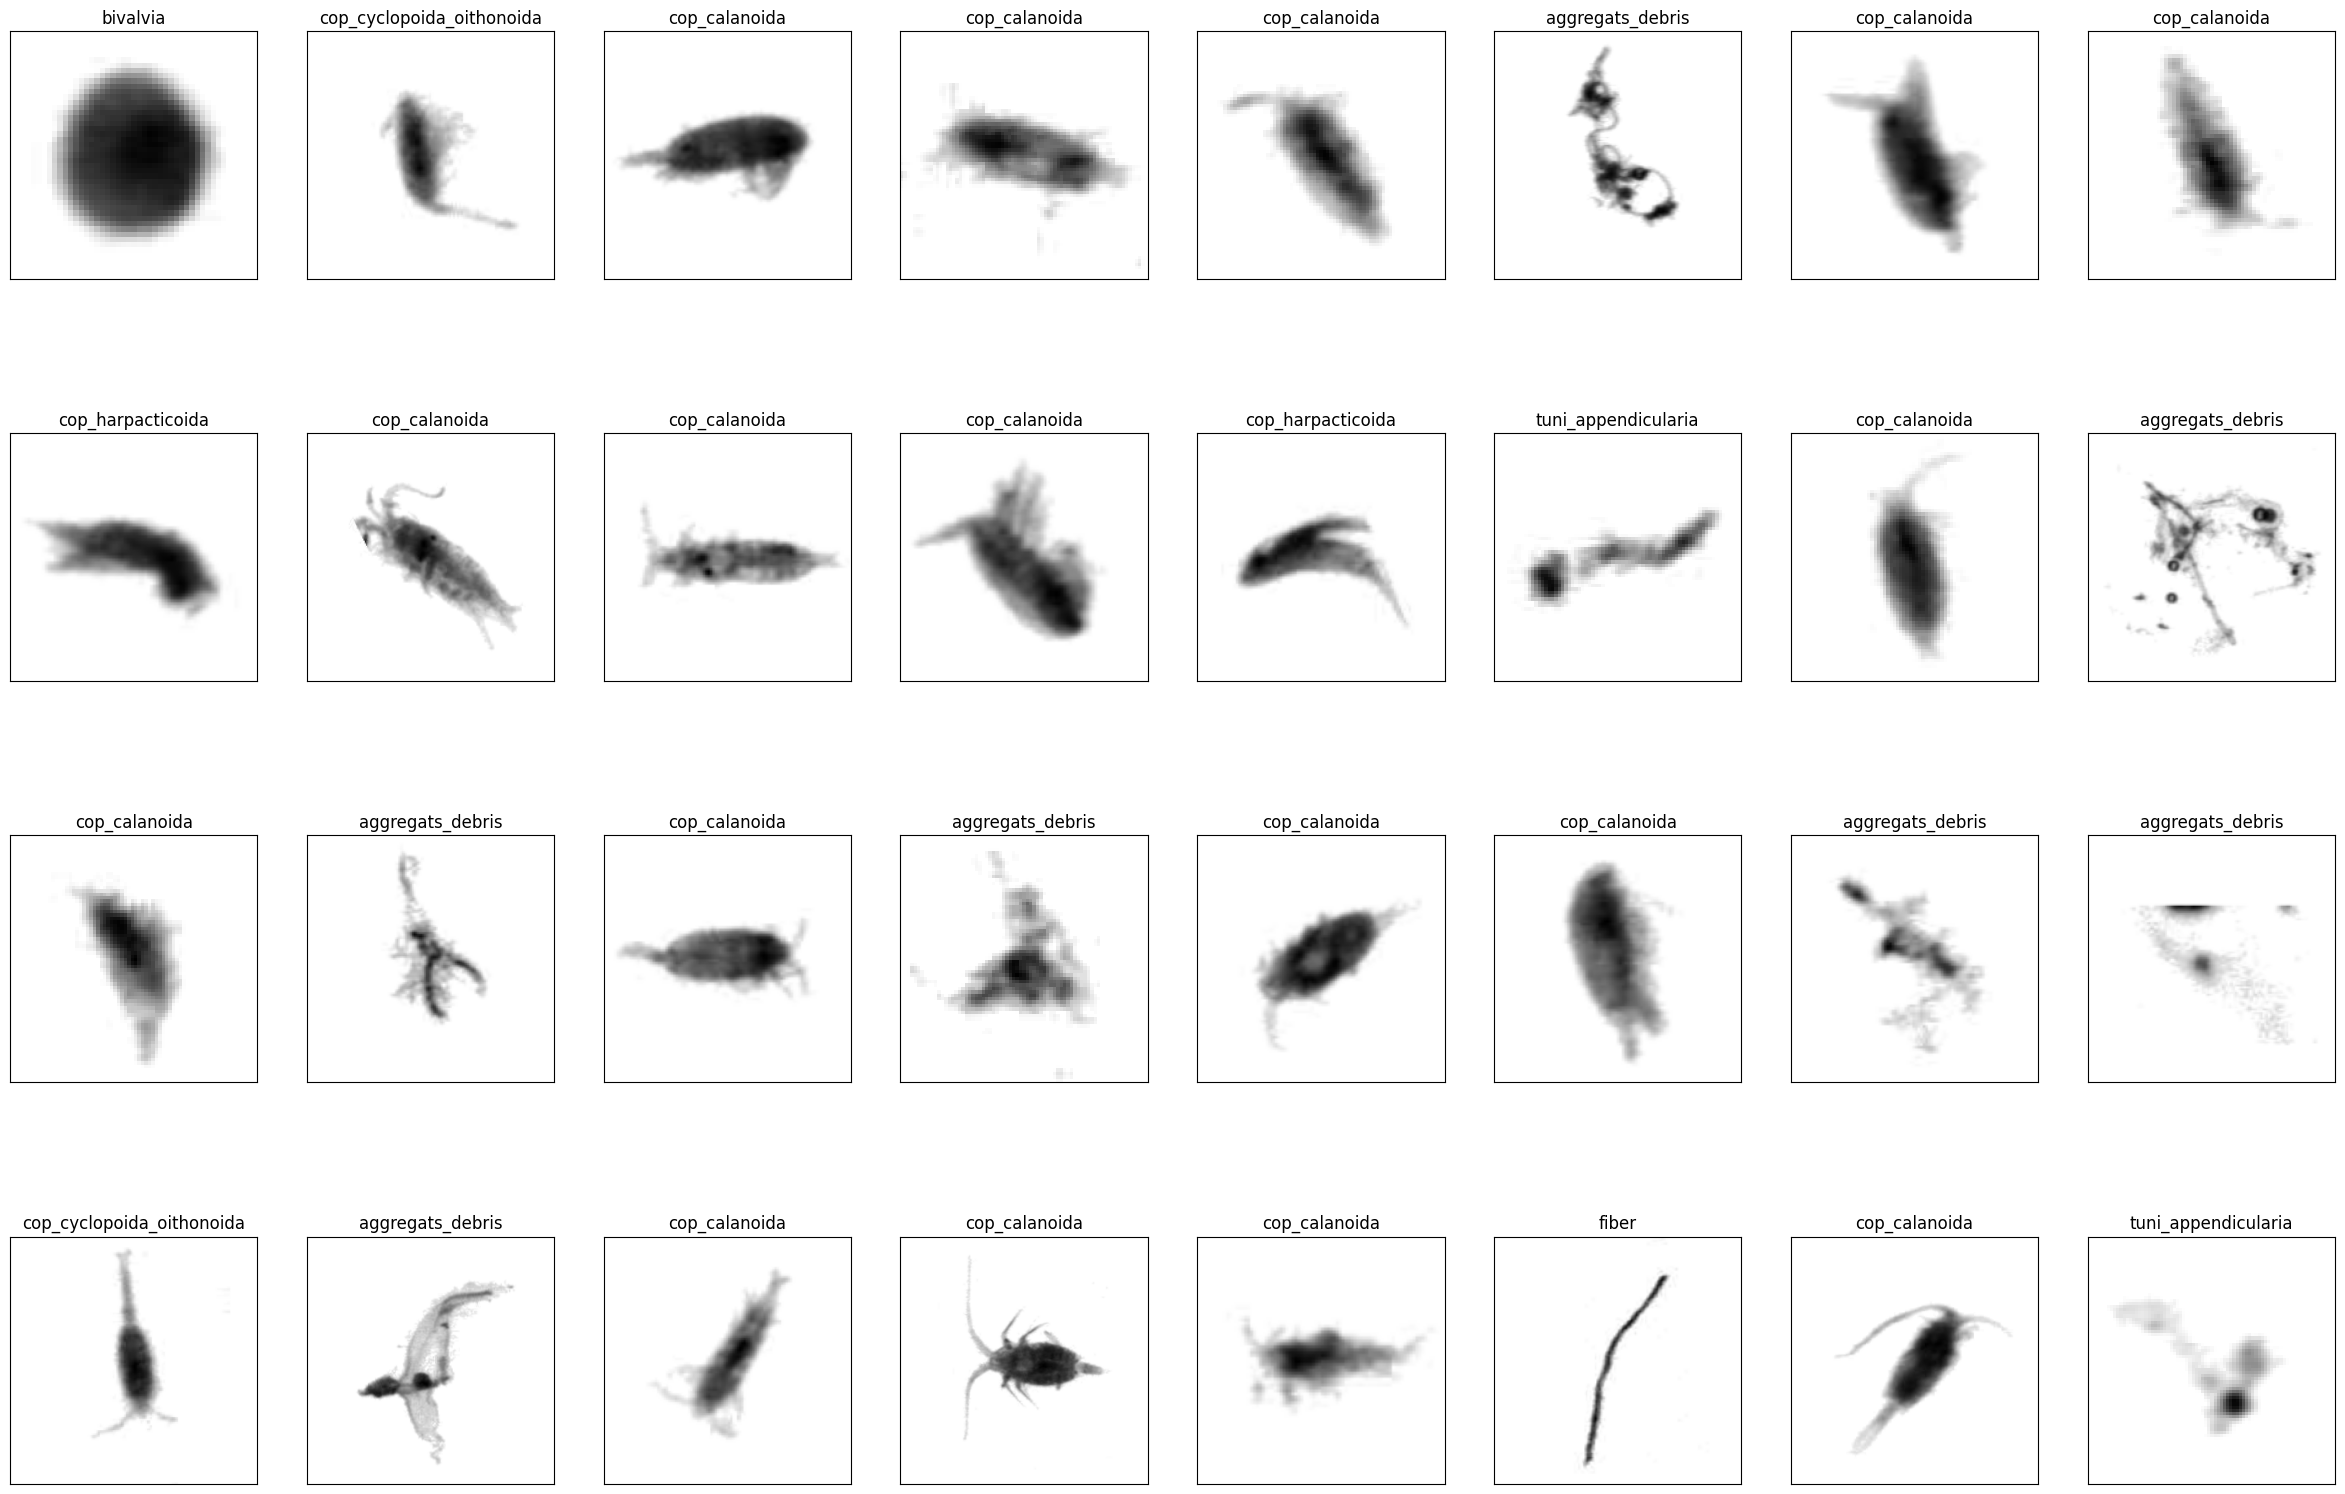

In [10]:
# show some random images in training set

plt.figure(figsize=(30, 20))
for i in range(32):
    row_df = X_train_df.sample()
    label = row_df['labels'].to_list()[0]
    ax = plt.subplot(4, 8, i + 1)
    plt.imshow(load_img(row_df['filenames'].to_list()[0], color_mode='rgb', interpolation="nearest"))
    ax.set_title(label)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

# One-hot encoder

In [11]:
train_features = X_features_train_df.copy(deep=True).iloc[:,1:]
train_labels = X_train_df['labels']

display(train_features.head(5), train_features.shape, type(train_features))
display(train_labels.head(5), train_labels.shape, type(train_labels))

train_features = train_features.to_numpy()
display(train_features[0:5], train_features.shape, type(train_features))

,1,2,3,4,5,6,7,8,9,10,...,2911,2912,2913,2914,2915,2916,2917,2918,2919,2920
0,-0.201468,-0.120201,-0.265277,1.345567,1.404456,-0.223910,-0.153469,-0.299044,0.760385,-0.093852,...,-0.637837,-0.265665,0.625102,0.406829,0.974950,-0.137263,-0.688936,0.322928,0.274049,0.385426
1,-0.201468,-0.120201,-0.265277,-0.103267,-0.106819,-0.223910,-0.153469,-0.413064,-0.107453,-0.093852,...,-0.477845,1.402088,-0.269257,-0.221349,-0.234698,2.023317,0.132266,0.596958,-0.340160,0.542286
2,-0.201468,-0.120201,-0.265277,-0.103267,-0.106819,0.538241,-0.153469,-0.413064,-0.107453,-0.093852,...,0.252886,-0.123262,0.024477,-0.496797,0.751898,2.025890,-0.115334,-1.173961,-2.982374,-1.454144
3,-0.201468,-0.120201,-0.265277,-0.103267,-0.106819,-0.223910,-0.153469,1.753329,-0.107453,-0.093852,...,0.896005,0.459168,0.046755,0.059574,0.314382,-1.254721,-0.171246,0.006423,-0.762859,1.357159
4,-0.201468,5.596114,-0.265277,-0.103267,-0.106819,-0.223910,-0.153469,-0.413064,-0.107453,-0.093852,...,0.681932,-0.537194,-1.186791,-1.369011,-0.281544,0.047441,1.273257,0.488321,-0.059476,0.358138


(44099, 2920)

pandas.core.frame.DataFrame

0    aggregats_debris
1    aggregats_debris
2    aggregats_debris
3    aggregats_debris
4    aggregats_debris
Name: labels, dtype: object

(44099,)

pandas.core.series.Series

array([[-0.20146782, -0.12020136, -0.26527717, ...,  0.32292757,
         0.27404928,  0.38542591],
       [-0.20146782, -0.12020136, -0.26527717, ...,  0.59695774,
        -0.34015951,  0.54228561],
       [-0.20146782, -0.12020136, -0.26527717, ..., -1.17396053,
        -2.98237448, -1.4541435 ],
       [-0.20146782, -0.12020136, -0.26527717, ...,  0.00642334,
        -0.76285869,  1.35715884],
       [-0.20146782,  5.59611432, -0.26527717, ...,  0.48832057,
        -0.05947581,  0.35813777]])

(44099, 2920)

numpy.ndarray

In [12]:
validation_features = X_features_validation_df.copy(deep=True).iloc[:,1:]
validation_labels = X_validation_df['labels']

display(validation_features.head(5), validation_features.shape, type(validation_features))
display(validation_labels.head(5), validation_labels.shape, type(validation_labels))

validation_features = validation_features.to_numpy()
display(validation_features[0:5], validation_features.shape, type(validation_features))

,1,2,3,4,5,6,7,8,9,10,...,2911,2912,2913,2914,2915,2916,2917,2918,2919,2920
0,-0.201468,-0.120201,-0.265277,-0.103267,-0.106819,-0.223910,-0.153469,-0.413064,-0.107453,-0.093852,...,0.520593,0.216804,5.766702,0.438995,-1.818535,-1.288561,1.216192,-0.018690,-2.220765,1.836242
1,-0.201468,-0.120201,-0.265277,-0.103267,-0.106819,-0.223910,-0.153469,-0.413064,-0.107453,-0.093852,...,-0.511078,0.134863,-0.178913,-0.092466,-0.350086,-0.673897,0.604665,-0.620063,0.169654,-0.531466
2,-0.201468,-0.120201,-0.265277,-0.103267,-0.106819,-0.223910,-0.153469,-0.413064,-0.107453,-0.093852,...,-2.214210,-0.196517,-0.527347,2.954624,-2.770604,-0.738247,-0.475386,-1.203956,0.853601,1.157176
3,-0.201468,-0.120201,-0.265277,-0.103267,-0.106819,0.735584,-0.153469,-0.413064,-0.107453,-0.093852,...,0.292169,0.242131,-0.143010,-0.418193,0.144117,0.249611,-0.087513,0.891432,-0.427881,0.152774
4,-0.201468,-0.120201,-0.265277,-0.103267,-0.106819,-0.223910,-0.153469,-0.413064,-0.107453,-0.093852,...,0.470533,0.932145,-0.219935,0.201913,0.247203,-0.175417,1.181583,-0.144998,0.481421,-0.387397


(14700, 2920)

pandas.core.frame.DataFrame

0    aggregats_debris
1    aggregats_debris
2    aggregats_debris
3    aggregats_debris
4    aggregats_debris
Name: labels, dtype: object

(14700,)

pandas.core.series.Series

array([[-0.20146782, -0.12020136, -0.26527717, ..., -0.01868964,
        -2.22076513,  1.83624158],
       [-0.20146782, -0.12020136, -0.26527717, ..., -0.62006274,
         0.16965395, -0.53146556],
       [-0.20146782, -0.12020136, -0.26527717, ..., -1.20395578,
         0.85360139,  1.15717597],
       [-0.20146782, -0.12020136, -0.26527717, ...,  0.89143183,
        -0.42788059,  0.15277444],
       [-0.20146782, -0.12020136, -0.26527717, ..., -0.14499804,
         0.48142061, -0.38739686]])

(14700, 2920)

numpy.ndarray

In [13]:
jobs_encoder = LabelBinarizer()
jobs_encoder.fit(train_labels)

LabelBinarizer()

In [14]:
train_labels_encoded = jobs_encoder.transform(train_labels)
validation_labels_encoded = jobs_encoder.transform(validation_labels)
# test_labels_encoded = jobs_encoder.transform(test_labels)

In [15]:
display(train_labels_encoded[0:5], train_labels_encoded.shape, type(train_labels_encoded))
display(validation_labels_encoded[0:5], validation_labels_encoded.shape, type(validation_labels_encoded))
# display(test_labels_encoded[0:5], test_labels_encoded.shape, type(test_labels_encoded))

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0]])

(44099, 29)

numpy.ndarray

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0]])

(14700, 29)

numpy.ndarray

In [16]:
train_labels_encoded[0]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0])

# 4. Create model CNN + SIFT

## 4.1. Set metrics

In [17]:
# compute class weights
X_TRAINING_df = pd.concat([X_train_df, X_validation_df], ignore_index=True)
classes = X_TRAINING_df.sort_values(by=['labels']).groupby('labels').size().to_frame('number of images').reset_index()
# display(classes)

from scipy.stats.mstats import gmean
count = classes['number of images'].values
# display(count)

weights_PT = gmean(count) / count
#print(weights_PT)

weights_PT[weights_PT < 0.1] = 0.1
weights_PT[weights_PT > 10] = 10
#print(weights_PT)

class_weights_PT = dict(enumerate(weights_PT))
display(class_weights_PT)


{0: 0.1,
 1: 1.9354720050942424,
 2: 0.8151469233073261,
 3: 1.194227407398575,
 4: 1.6036768042209437,
 5: 0.1,
 6: 0.11763497515991952,
 7: 0.1456806885554806,
 8: 0.40715110573485097,
 9: 4.0091920105523595,
 10: 4.050523886949806,
 11: 10.0,
 12: 10.0,
 13: 0.9653582728111332,
 14: 0.20581499058885866,
 15: 1.4133122914896805,
 16: 1.2239900842184772,
 17: 2.6911014865351452,
 18: 7.555784942964062,
 19: 0.14418378606757107,
 20: 1.5228713838532217,
 21: 10.0,
 22: 0.8869092935307702,
 23: 1.8446047748081276,
 24: 1.368992393847147,
 25: 2.0045960052761798,
 26: 0.19128569475858384,
 27: 0.3597992829982886,
 28: 0.931044590128273}

In [18]:
from keras_tuner.tuners import BayesianOptimization, Hyperband
import keras_tuner

In [19]:
ROOT= f"..//_outputs"
MODEL_NAME = "_MLPOps"

TAGS = "_Zooscan"

# Setup folders

date_time = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

OUTPUT_DIR = f"{ROOT}"

if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)
    #print("The folder", OUTPUT_DIR, "has been created!")
#else:
#   print("The folder", OUTPUT_DIR, "exists!")

MODEL_DIR = f"{OUTPUT_DIR}//{MODEL_NAME}" 

if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)
    #print("The folder", MODEL_DIR, "has been created!")
#else:
#    print("The folder", MODEL_DIR, "exists!")

LOG_DIR = f"{MODEL_DIR}//_Zooscan"

if not os.path.exists(LOG_DIR):
    os.mkdir(LOG_DIR)
#    print("The folder", LOG_DIR, "has been created!")
#else:
#    print("The folder", LOG_DIR, "exists!")

LOGTIME_DIR = f"{LOG_DIR}//{TAGS}_{date_time}"

if not os.path.exists(LOGTIME_DIR):
    os.mkdir(LOGTIME_DIR)
#    print("The folder", LOGTIME_DIR, "has been created!")
#else:
#    print("The folder", LOGTIME_DIR, "exists!")



In [20]:
display(LOGTIME_DIR)

'..//_outputs//_MLPOps//_Zooscan//_Zooscan_20230627-173621'

# Find the optimal:
    -   number of hidden layers
    -   number of neurons per layer
    -   value of dropout rate
    -   use Batchnormalization or not


class RollingBuffer:

    def __init__(self, buffer_len):
        self.__buffer = np.zeros(buffer_len)
        self.__counter = 0
        self.__buffer_len = buffer_len

    def append(self, data):
        self.__buffer = np.roll(self.__buffer, -1)
        self.__buffer[-1] = data
        self.__counter += 1
        if self.__counter > self.__buffer_len:
            self.__counter = self.__buffer_len

    def values(self):
        return self.__buffer[-self.__counter:]

    def mean(self):
        return np.sum(self.__buffer) / self.__counter

    def indices(self):
        return range(self.__counter)

    def clear(self):
        self.__counter = 0

    def length(self):
        return self.__buffer_len

    def full(self):
        return self.__counter == self.__buffer_len

    def slope_probability_less_than(self, prob):
        idxs = self.indices()
        n = len(idxs)
        if n < 3:
            return 1
        values = self.values()
        n = float(n)
        slope, intercept, r_value, p_value, std_err = stats.linregress(idxs, values)
        residuals = idxs * slope + intercept
        variance = np.sum(np.power(residuals - values, 2)) / (n - 2)
        slope_std_error = np.sqrt(variance * (12.0 / (np.power(n, 3) - n)))
        p_less_than_zero = stats.norm.cdf(prob, slope, slope_std_error)
        return p_less_than_zero


def graph_to_console(epoch, batch, acc, loss, val_acc, val_loss, macrof1score, val_macrof1score, lr_prob, lr_prob_active, time_difference):
    acc_i = round(acc * 50)
    val_acc_i = round(val_acc * 50)
    lr_prob_i = round(lr_prob * 50)

    macrof1score_i = round(macrof1score * 50)
    val_macrof1score_i = round(val_macrof1score * 50)


    for j in range(51):
        if j == acc_i:
            print('#', end="")
        # elif j == trainsdi:
        #     print('@', end="")
        elif j == val_acc_i:
            print('*', end="")
        elif j == lr_prob_i and j != 100 and lr_prob_active:
            print('+', end="")
        elif j % 10 == 0:
            print('|', end="")
        elif j == macrof1score_i:
            print('$', end="")
        elif j == val_macrof1score_i:
            print('$_$', end="")
        else:
            print(' ', end="")
    # msg = " {} #T {:.1f}%/{:.4f}, *V {:.1f}%/{:.4f} ({:.2f}s)"
    # print(msg.format(epoch, acc * 100, loss, val_acc * 100, val_loss, time_difference))
    msg = " {} #T{:.1f}%/*V{:.1f}%/$T{:.1f}%/$_$V{:.1f} ({:.2f}s)"
    print(msg.format(epoch, acc * 100, val_acc * 100, macrof1score*100, val_macrof1score*100, time_difference))


class AdaptiveLearningRateScheduler(Callback):
    """
    Adaptive learning rate scheduler

    Decreases learning rate by a certain factor each time it is no longer improving
    """

    def __init__(self, drop_rate=0.5, nb_drops=4, nb_epochs=10, verbose=1, monitor='val_macrof1score'):
        super(AdaptiveLearningRateScheduler, self).__init__()
        self.monitor = monitor
        self.drop_rate = drop_rate
        self.nb_drops = nb_drops
        self.nb_epochs = nb_epochs
        self.verbose = verbose
        self.current_epoch = 0
        self.current_batch = 0
        self.drop_count = 0
        self.buffer = None
        self.previous_time = None
        self.finished = False

    def on_train_begin(self, logs=None):
        # if 'batch_size' in self.params and self.params['batch_size'] is not None:
        #     batch_size = self.params['batch_size']
        #     samples = self.params['samples']
        #     self.buffer = RollingBuffer(math.ceil(samples * self.nb_epochs / batch_size))
        # else:
        self.buffer = RollingBuffer(self.nb_epochs)
        self.previous_time = time.time()

    def on_epoch_begin(self, epoch, logs=None):
        self.current_epoch = epoch

    def on_epoch_end(self, epoch, logs=None):
        loss = logs.get("loss")
        acc = logs.get("acc") or logs.get('accuracy') or logs.get('iou_score') or logs.get('cosine_proximity')
        val_loss = logs.get("val_loss") or 0
        val_acc = logs.get("val_acc") or logs.get('val_accuracy') or logs.get('val_iou_score') or logs.get(
            'val_cosine_proximity') or 0
        if 'cosine_proximity' in logs:
            acc += 1
            val_acc += 1

        macrof1score = logs.get("f1")
        val_macrof1score = logs.get("val_f1")

        # Elapsed time
        current_time = time.time()
        if self.previous_time is None:
            time_difference = 0
        else:
            time_difference = current_time - self.previous_time
        self.previous_time = current_time

        # Update learning rate
        self.update_learning_rate(self.current_epoch, logs)

        # Graph to console
        if val_acc is not None:
            print("\r", end="")
            graph_to_console(self.current_epoch, self.current_batch,
                             acc, loss, val_acc, val_loss, macrof1score, val_macrof1score,
                             self.buffer.slope_probability_less_than(0), self.buffer.full(),
                             time_difference)

        if self.finished is True:
            self.model.stop_training = True
            print("Training finished".format(self.model.optimizer.lr))

    def on_batch_end(self, batch, logs=None):
        self.current_batch += 1

    def update_learning_rate(self, count, logs):
        monitor_value = logs.get(self.monitor)
        self.buffer.append(monitor_value)

        if count >= self.buffer.length() * 3 and self.buffer.full() and self.finished is False:
            # if count % 20 == 19:
            #     lr = float(K.get_value(self.model.optimizer.lr))
            #     new_lr = lr * self.drop_rate
            #     K.set_value(self.model.optimizer.lr, new_lr)
            #     print("Learning rate dropped ({}/{}) to {}".format(self.drop_count, self.nb_drops, new_lr))
            if self.buffer.slope_probability_less_than(0) < 0.50:
                lr = float(K.get_value(self.model.optimizer.lr))
                # lr = self.model.optimizer.lr.read_value()
                new_lr = lr * self.drop_rate
                K.set_value(self.model.optimizer.lr, new_lr)
                # self.model.optimizer.lr.assign(new_lr)
                self.buffer.clear()
                self.drop_count += 1
                if self.drop_count == self.nb_drops:
                    self.finished = True
                    return
                if self.verbose == 1:
                    print("Learning rate dropped ({}/{}) to {}".format(self.drop_count, self.nb_drops, new_lr))

In [21]:
def build_model(hp):
    num_classes = 29

    feature_input = Input(shape=(2920,), name="image_features")  # input layer
    
    feature_network = feature_input
    
   
    # Determine the number of hidden layers
    num_hidden_layers = hp.Int('num_hidden_layers', 1, 5, default=1)
    
    
    for i in range(num_hidden_layers):

        # Determine the number of neurons in each hidden layer
        num_neurons = hp.Int(name='num_neurons_' + str(i), min_value=512, max_value=4096, step=256, default=2048)
        feature_network = Dense(units=num_neurons, activation='relu')(feature_network)
        
        # Determine the dropout rate
        rate_dropout = hp.Float(name='dropout_rate_' + str(i), min_value= 0.0, max_value=0.8, step=0.1, default=0.3)
        feature_network = Dropout(rate_dropout)(feature_network)

        # Determine the use of BatchNormalization
        use_batchnorm = hp.Boolean(name='use_batchnorm_' + str(i), default = False)
        if use_batchnorm:
            feature_network = BatchNormalization()(feature_network)
    
    # output layer
    classfier_layer = Dense(num_classes, activation='softmax', name='classifier')(feature_network)
    
    model = Model(
                    inputs=feature_input,
                    outputs=classfier_layer
                    )

    # set calibration metric, optimization and loss function
    METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tfa.metrics.F1Score(num_classes=num_classes, average='macro', name='f1') # macro f1-score
            ]
    
    model.compile(
                optimizer='adam',
                loss="categorical_crossentropy",
                metrics=[METRICS])
    
    
    return model

In [ ]:
early_stop = EarlyStopping(
    monitor='val_f1',  # Metric to monitor for improvement
    patience=50,  # Number of epochs with no improvement
    restore_best_weights=True,  # Restore the weights of the best model
    mode='max',
    min_delta=0.001
)

In [ ]:
# LOGTIME_DIR= '..//_outputs//_MLPOps//_Zooscan//_Zooscan_20230621-151007'
# LOGTIME_DIR= '..//_outputs//_MLPOps//_Zooscan//_Zooscan_20230623-111816'
tuner = BayesianOptimization(
                                build_model,
                                objective = keras_tuner.Objective("val_f1", direction="max"),
                                max_trials=200,
                                executions_per_trial=1,
                                directory=LOGTIME_DIR,
                                project_name='Hyperparameters-MLP'
                                )

In [ ]:
tuner.search_space_summary()

from tensorflow.python.client import device_lib

local_device_protos = device_lib.list_local_devices()
gpu_devices = [device.name for device in local_device_protos if device.device_type == 'GPU']
print(gpu_devices)

In [ ]:
print("[INFO] performing hyperparameter search...")

strategy = tf.distribute.OneDeviceStrategy('/device:GPU:0')

with strategy.scope():

    tuner.search(
                x=train_features, y=train_labels_encoded,
                validation_data=(validation_features, validation_labels_encoded),
                callbacks=[early_stop, reduce_lr],
                class_weight=class_weights_PT,
                epochs=1000,
                workers=2,
                verbose=1
                )

In [ ]:
tuner.results_summary()

In [ ]:
tuner.results_summary()[0]

In [ ]:
bestHP = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:

print("[INFO] optimal number of hidden layer: {}".format(bestHP.get("num_hidden_layers")))
print("[INFO] optimal number of neurons: {}".format(bestHP.get("num_neurons_1")))


In [ ]:
model = tuner.hypermodel.build(bestHP)

In [ ]:
model.summary()

# Setup adaptive learning rates

In [ ]:
import scipy.stats as stats

class RollingBuffer:

    def __init__(self, buffer_len):
        self.__buffer = np.zeros(buffer_len)
        self.__counter = 0
        self.__buffer_len = buffer_len

    def append(self, data):
        self.__buffer = np.roll(self.__buffer, -1)
        self.__buffer[-1] = data
        self.__counter += 1
        if self.__counter > self.__buffer_len:
            self.__counter = self.__buffer_len

    def values(self):
        return self.__buffer[-self.__counter:]

    def mean(self):
        return np.sum(self.__buffer) / self.__counter

    def indices(self):
        return range(self.__counter)

    def clear(self):
        self.__counter = 0

    def length(self):
        return self.__buffer_len

    def full(self):
        return self.__counter == self.__buffer_len

    def slope_probability_less_than(self, prob):
        idxs = self.indices()
        n = len(idxs)
        if n < 3:
            return 1
        values = self.values()
        n = float(n)
        slope, intercept, r_value, p_value, std_err = stats.linregress(idxs, values)
        residuals = idxs * slope + intercept
        variance = np.sum(np.power(residuals - values, 2)) / (n - 2)
        slope_std_error = np.sqrt(variance * (12.0 / (np.power(n, 3) - n)))
        p_less_than_zero = stats.norm.cdf(prob, slope, slope_std_error)
        return p_less_than_zero

In [ ]:

from tensorflow.keras.callbacks import Callback, LearningRateScheduler

import math
import time


def graph_to_console(epoch, batch, acc, loss, val_acc, val_loss, macrof1score, val_macrof1score, lr_prob, lr_prob_active, time_difference):
    acc_i = round(acc * 50)
    val_acc_i = round(val_acc * 50)
    lr_prob_i = round(lr_prob * 50)

    macrof1score_i = round(macrof1score * 50)
    val_macrof1score_i = round(val_macrof1score * 50)

    for j in range(51):
        if j == acc_i:
            print('#', end="")
        # elif j == trainsdi:
        #     print('@', end="")
        elif j == val_acc_i:
            print('*', end="")
        elif j == lr_prob_i and j != 100 and lr_prob_active:
            print('+', end="")
        elif j % 10 == 0:
            print('|', end="")
        elif j == macrof1score_i:
            print('$', end="")
        elif j == val_macrof1score_i:
            print('$_$', end="")
        else:
            print(' ', end="")
    # msg = " {} #T {:.1f}%/{:.4f}, *V {:.1f}%/{:.4f} ({:.2f}s)"
    # print(msg.format(epoch, acc * 100, loss, val_acc * 100, val_loss, time_difference))
    msg = " {} #T{:.1f}%/*V{:.1f}%/$T{:.1f}%/$_$V{:.1f} ({:.2f}s)"
    print(msg.format(epoch, acc * 100, val_acc * 100, macrof1score*100, val_macrof1score*100, time_difference))


class AdaptiveLearningRateScheduler(Callback):
    """
    Adaptive learning rate scheduler

    Decreases learning rate by a certain factor each time it is no longer improving
    """

    def __init__(self, drop_rate=0.5, nb_drops=4, nb_epochs=10, verbose=1, monitor='val_macrof1score'):
        super(AdaptiveLearningRateScheduler, self).__init__()
        self.monitor = monitor
        self.drop_rate = drop_rate
        self.nb_drops = nb_drops
        self.nb_epochs = nb_epochs
        self.verbose = verbose
        self.current_epoch = 0
        self.current_batch = 0
        self.drop_count = 0
        self.buffer = None
        self.previous_time = None
        self.finished = False

    def on_train_begin(self, logs=None):
        # if 'batch_size' in self.params and self.params['batch_size'] is not None:
        #     batch_size = self.params['batch_size']
        #     samples = self.params['samples']
        #     self.buffer = RollingBuffer(math.ceil(samples * self.nb_epochs / batch_size))
        # else:
        self.buffer = RollingBuffer(self.nb_epochs)
        self.previous_time = time.time()

    def on_epoch_begin(self, epoch, logs=None):
        self.current_epoch = epoch

    def on_epoch_end(self, epoch, logs=None):
        loss = logs.get("loss")
        acc = logs.get("acc") or logs.get('accuracy') or logs.get('iou_score') or logs.get('cosine_proximity')
        val_loss = logs.get("val_loss") or 0
        val_acc = logs.get("val_acc") or logs.get('val_accuracy') or logs.get('val_iou_score') or logs.get(
            'val_cosine_proximity') or 0
        if 'cosine_proximity' in logs:
            acc += 1
            val_acc += 1

        macrof1score = logs.get("macrof1score")
        val_macrof1score = logs.get("val_macrof1score")

        # Elapsed time
        current_time = time.time()
        if self.previous_time is None:
            time_difference = 0
        else:
            time_difference = current_time - self.previous_time
        self.previous_time = current_time

        # Update learning rate
        self.update_learning_rate(self.current_epoch, logs)

        # Graph to console
        if val_acc is not None:
            print("\r", end="")
            graph_to_console(self.current_epoch, self.current_batch,
                             acc, loss, val_acc, val_loss, macrof1score, val_macrof1score,
                             self.buffer.slope_probability_less_than(0), self.buffer.full(),
                             time_difference)

        if self.finished is True:
            self.model.stop_training = True
            print("Training finished".format(self.model.optimizer.lr))

    def on_batch_end(self, batch, logs=None):
        self.current_batch += 1

    def update_learning_rate(self, count, logs):
        monitor_value = logs.get(self.monitor)
        self.buffer.append(monitor_value)

        if count >= self.buffer.length() * 3 and self.buffer.full() and self.finished is False:
            # if count % 20 == 19:
            #     lr = float(K.get_value(self.model.optimizer.lr))
            #     new_lr = lr * self.drop_rate
            #     K.set_value(self.model.optimizer.lr, new_lr)
            #     print("Learning rate dropped ({}/{}) to {}".format(self.drop_count, self.nb_drops, new_lr))
            if self.buffer.slope_probability_less_than(0) < 0.50:
                lr = float(K.get_value(self.model.optimizer.lr))
                # lr = self.model.optimizer.lr.read_value()
                new_lr = lr * self.drop_rate
                K.set_value(self.model.optimizer.lr, new_lr)
                # self.model.optimizer.lr.assign(new_lr)
                self.buffer.clear()
                self.drop_count += 1
                if self.drop_count == self.nb_drops:
                    self.finished = True
                    return
                if self.verbose == 1:
                    print("Learning rate dropped ({}/{}) to {}".format(self.drop_count, self.nb_drops, new_lr))

In [ ]:
from keras.utils.vis_utils import plot_model

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
def create_Callbakcs(strBestModelName):
    
    reduce_lr = ReduceLROnPlateau(monitor='val_prc',  mode='max', factor=0.2, min_delta=0.001, patience=10, min_lr=1e-6, verbose=1)
    early_stopping = EarlyStopping(patience=20, monitor='val_prc', min_delta=0.001, verbose=1, mode='max') # calibration metric = "val+prc"
    model_checkpoint = ModelCheckpoint(strBestModelName, monitor="val_prc", save_best_only=True, verbose=1, mode='max')
    
    return [reduce_lr, early_stopping, model_checkpoint]

MODEL_CHECKPOINTS = 'testing-best_model-fold.hdf5'

In [ ]:
MODEL_CHECKPOINTS = 'testing-best_model-fold.hdf5'

In [ ]:
model.fit(
            x=train_features, y=train_labels_encoded,
            validation_data=(validation_features, validation_labels_encoded),
            epochs=500, 
            batch_size=32,
            callbacks=create_Callbakcs(MODEL_CHECKPOINTS), 
            class_weight=class_weights_PT,
            verbose=1)

In [ ]:
print("Evaluate model on test data")
results = model.evaluate(test_features, test_labels_encoded, batch_size=32)
print("test loss, test acc:", results)

In [ ]:
# Generate a prediction using model.predict() 
# and calculate it's shape:
print("Generate a prediction")
prediction = model.predict(test_features)
print("prediction shape:", prediction.shape)

In [ ]:
prediction

In [ ]:
test_pred = prediction.argmax(axis=1).tolist()

In [ ]:
test_true_labels_encoded = test_labels_encoded.argmax(axis=1).tolist()

In [ ]:
test_true_labels_encoded[1]

In [ ]:
test_pred[1]

In [ ]:
print(classification_report(test_true_labels_encoded, test_pred), sep='')

In [ ]:
test_pred = prediction.argmax(axis=1).tolist()
test_true = test_labels_encoded

num_per_targetNames = Counter(test_iterator.classes)
print(num_per_targetNames)
targetNames=list(test_iterator.class_indices.keys())
print(targetNames)

# Accuracy, Precision, Recall, F1 score
print(classification_report(test_true, test_pred, target_names=targetNames), sep='')

REPORT_filename = f'{LOGTIME_DIR}//{CNN_MODEL_NAME}-classification_report-test_set-fold_{fold}.csv'
df_classification_report = pd.DataFrame(classification_report(test_true, test_pred, target_names=targetNames, digits=2, output_dict=True)).transpose()
df_classification_report.to_csv(REPORT_filename)


### **5.3. Start to train the CNN**

In [ ]:
del model
K.clear_session()
gc.collect()

In [ ]:
path = os.path.abspath('CyclicLR.py')
print(path)
spec = importlib.util.spec_from_file_location("CyclicLR", path)
foo3 = importlib.util.module_from_spec(spec)
spec.loader.exec_module(foo3)
foo3.CyclicLR


def create_Callbakcs(strBestModelName, steps_per_epoch):

    min_learningRate = 1e-05 # minimum learning rate
    max_learningRate = 1e-3  # maximum learning rate
    
    clr_triangular = foo3.CyclicLR(base_lr=min_learningRate, max_lr=max_learningRate,step_size=4*steps_per_epoch, mode='triangular2')

    early_stopping = EarlyStopping(patience=20, monitor='val_prc', min_delta=0.001, verbose=1, mode='max') # calibration metric = "val+prc"
    model_checkpoint = ModelCheckpoint(strBestModelName, monitor="val_prc", save_best_only=True, verbose=1, mode='max')
    
    return [clr_triangular, early_stopping, model_checkpoint]

In [ ]:
all_history={}

fold='manual'

train_iterator = MyCustomImageDataGenerator(X_train_df, x_col = 'filenames', y_col='labels', z_col='short_filenames', 
                                      datagen=train_gen, 
                                      feature_1_df=X_features_train_df, 
                                      batch_size=BATCH_SIZE, 
                                      shuffle=True,
                                     target_size=IMG_SIZE,
                                     color_mode= COLOR_MODE)

validation_iterator = MyCustomImageDataGenerator(X_validation_df, x_col = 'filenames', y_col='labels', z_col='short_filenames', 
                                   datagen=validation_gen, 
                                      feature_1_df=X_features_validation_df, 
                                      batch_size=BATCH_SIZE, 
                                      shuffle=False,
                                     target_size=IMG_SIZE,
                                     color_mode= COLOR_MODE)

steps_per_epoch = train_iterator.__len__()


print("... Working at fold ", fold, "...")
print("\t step per epoch is: ", steps_per_epoch)


# load initial model
json_file = open(MODEL_ARCHITECHTURE_JSON, 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

OPTIMIZER = Adam(learning_rate=1e-05)
    
LOSS = CategoricalCrossentropy()

METRICS = [ 
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

print("\t 1. Reloading initial weights of the CNN model...")
model.load_weights(MODEL_WEIGHTS_INITIAL)

print("\t 1.1. Re-compiling the CNN model...")
model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)

print("\t 2. Starting training the model...")
start = time.time()

MODEL_CHECKPOINTS = f'{LOGTIME_DIR}//{CNN_MODEL_NAME}-best_model-fold_{fold}.hdf5'

myCallbacks = create_Callbakcs(strBestModelName=MODEL_CHECKPOINTS, steps_per_epoch = steps_per_epoch)

print("\t\t 2.1. Best model will be stored in the file: ", MODEL_CHECKPOINTS)

history_TLearning = model.fit(
                                train_iterator, 
                                validation_data = validation_iterator, 
                                epochs = MAX_EPOCHS,
                                callbacks=myCallbacks, 
                                class_weight=class_weights_PT,
                                verbose=0
                                )

time_done = time.time() - start

print("\t\t 2.2. Total time for training the CNN model in fold ", fold, "is: ", time_done, "seconds")

MODEL_TIME = f'{LOGTIME_DIR}//{CNN_MODEL_NAME}-TrainingTime-fold_{fold}.txt'
with open(MODEL_TIME, mode='w') as file:
    file.write('Total time for training the CNN model: %3f seconds.\n' %time_done)


MODEL_WEIGHTS_FINAL = f'{LOGTIME_DIR}//{CNN_MODEL_NAME}-model_weights_final-fold_{fold}.hdf5'
print("\t\t 2.3. Model at final epoch will be stored in the file: ", MODEL_WEIGHTS_FINAL)
model.save_weights(MODEL_WEIGHTS_FINAL)


#save whole model at final epoch of training process
MODEL_FINAL_EPOCH = f'{LOGTIME_DIR}//{CNN_MODEL_NAME}-model_final_epoch-fold_{fold}.hdf5'
print("\t\t 2.4. Model's weights at final epoch will be stored in the folder: ", MODEL_FINAL_EPOCH)
model.save(MODEL_FINAL_EPOCH)

# convert the history.history dict to a pandas DataFrame
# Save the history to CSV for further visualization
hist_df = pd.DataFrame(history_TLearning.history.copy()) 

HISTORY_CSV = f'{LOGTIME_DIR}//{CNN_MODEL_NAME}-History-fold_{fold}.csv'
print("\t\t 2.5. Learning curve of the model will be stored in the file: ", HISTORY_CSV)

with open(HISTORY_CSV, mode='w') as f:
    hist_df.to_csv(f)

print("... Ended fold ", fold, "...\n\n")

all_history[f'history-fold-{fold}'] = history_TLearning

# path = os.path.abspath('plot_result.py')
print(path)
spec = importlib.util.spec_from_file_location("plot_result", path)
foo2 = importlib.util.module_from_spec(spec)
spec.loader.exec_module(foo2)
foo2.plot_result

In [ ]:
path = os.path.abspath('plot_result.py')
print(path)
spec = importlib.util.spec_from_file_location("plot_result", path)
foo2 = importlib.util.module_from_spec(spec)
spec.loader.exec_module(foo2)
foo2.plot_result

In [ ]:
foo2.plot_result(LOGTIME_DIR, all_history) 

In [ ]:
for index, history in enumerate(all_history):
        acc = np.array(all_history[history].history['accuracy'].copy())*100
        val_acc = np.array(all_history[history].history['val_accuracy'].copy())*100
        loss = all_history[history].history['loss'].copy()
        val_loss = all_history[history].history['val_loss'].copy()
        epochs = range(len(acc))

        # plt.figure(figsize=(15, 5))
        # plt.plot(epochs, acc, 'b*-', label='Training accuracy')
        # plt.plot(epochs, val_acc, 'r*-', label='Validation accuracy')
        # plt.grid()
        # plt.title('Training and validation accuracy')
        # plt.ylabel("Accuracy")
        # plt.xlabel("Epochs")
        # plt.legend()
        # # plt.savefig(f'{folder}/fold-{index+1}-acc.png')
        # plt.figure()
        # plt.show()
        
        markersize=10
        linewidth=2
        fontsize=22
        
        # create figure and axis objects with subplots()
        fig, ax1 = plt.subplots(figsize=(20, 10))
        # make a plot
        p1, = ax1.plot(epochs, acc, 'r^-', linewidth=linewidth, markersize=markersize, label='Training accuracy')
        p2, = ax1.plot(epochs, val_acc, 'b^-', linewidth=linewidth, markersize=markersize, label='Validation accuracy')
        # set x-axis label
        ax1.set_xlabel("Epochs",fontsize=fontsize)
        # set y-axis label
        ax1.set_ylabel("Accuracy",fontsize=fontsize)
        # ax.set_ylim([0, 100])
        
        # twin object for two different y-axis on the sample plot
        ax2 = ax1.twinx()
        # make a plot with different y-axis using second axis object
        p3, = ax2.plot(epochs, loss, 'ro-', linewidth=linewidth, markersize=markersize, label='Training Loss')
        p4, = ax2.plot(epochs, val_loss, 'bo-', linewidth=linewidth, markersize=markersize, label='Validation Loss')
        
        ax2.set_ylabel("Loss",fontsize=fontsize) 
        # ax2.set_ylim([0, 2])
        
        ax1.set_yticks(np.linspace(40, 100, 7),fontsize=fontsize)
        ax2.set_yticks(np.round(np.linspace(0, 2, 7),1), fontsize=fontsize)

        ax1.grid(), 
        # ax2.grid()
        # ax.legend()
        plt.legend(ncol=2, handles=[p1, p2,p3,p4],fontsize=fontsize-4)
        
        ax1.tick_params(axis='x', labelsize=fontsize-4)
        ax1.tick_params(axis='y', labelsize=fontsize-4)
        
        ax2.tick_params(axis='y', labelsize=fontsize-4)
        
#         for tick in ax1.xaxis.get_major_ticks():
#                 tick.label.set_fontsize(fontsize) 
#         for tick in ax2.xaxis.get_major_ticks():
#                 tick.label.set_fontsize(fontsize) 
                
#         for tick in ax1.yaxis.get_major_ticks():
#                 tick.label.set_fontsize(fontsize) 
#         for tick in ax2.yaxis.get_major_ticks():
#                 tick.label.set_fontsize(fontsize) 
                
        plt.show()
        
        # save the plot as a file
        fig.savefig(f'{LOGTIME_DIR}/fold-{index+1}-accuracy_loss.jpg',
                    format='jpeg',
                    dpi=600,
                    bbox_inches='tight')

#         plt.figure(figsize=(15, 5))
#         loss = all_history[history].history['loss'].copy()
#         val_loss = all_history[history].history['val_loss'].copy()
#         plt.plot(epochs, loss, 'b*-', label='Training Loss')
#         plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
#         plt.grid()
#         plt.title('Training and validation loss')
#         plt.ylabel("Loss")
#         plt.xlabel("Epochs")
#         plt.legend()
#         plt.savefig(f'{folder}/fold-{index+1}-loss.png')
#         plt.figure()
#         plt.show()
        
#         plt.figure(figsize=(15, 5))
#         prc = all_history[history].history['prc'].copy()
#         val_prc = all_history[history].history['val_prc'].copy()
#         plt.plot(epochs, prc, 'b*-', label='Training AUPRC')
#         plt.plot(epochs, val_prc, 'r*-', label='Validation AUPRC')
#         plt.grid()
#         plt.title('Training and validation AUPRC')
#         plt.ylabel("AUPRC")
#         plt.xlabel("Epochs")
#         plt.legend()
#         plt.savefig(f'{folder}/fold-{index+1}-AUPRC.png')
#         plt.figure()
#         plt.show()

# 5. Evaluate model

## 5.1 Evaluate on validation sets

In [ ]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

path = os.path.abspath('plotConfusionMatrix.py')
print(path)
spec = importlib.util.spec_from_file_location("plot_confusion_matrix", path)
foo5 = importlib.util.module_from_spec(spec)
spec.loader.exec_module(foo5)
foo5.plot_confusion_matrix

from sklearn.metrics import balanced_accuracy_score, jaccard_score, average_precision_score, accuracy_score, recall_score

def calc_ClassBalancedAccuracy(confusion_matrix, classes_values, class_names): 
    result=0
    class_number = len(class_names)
    for i in classes_values:
        result += confusion_matrix[i][i] / max(sum(confusion_matrix[i,0:]), sum(confusion_matrix[0:,i]))

    result /= class_number
    
    return result


def computeGeometricAverageOfRecall(test_true, test_pred):
    result = 1.0
    for label in np.unique(test_true):
        idx = (test_true==label)
        result *= accuracy_score(np.array(test_true)[idx],np.array(test_pred)[idx])

    result = np.power(result, 1/len(np.unique(test_true)))

    return result


display(MODEL_CHECKPOINTS)

display(LOGTIME_DIR)

display(CNN_MODEL_NAME)

In [ ]:
GMeanRecalls=[]
AverageAccuracies=[]
ClassBalanceAccuracies=[]

fold = 'manual'


model_filename = f'{LOGTIME_DIR}//{CNN_MODEL_NAME}-best_model-fold_{fold}.hdf5'

model = tf.keras.models.load_model(
                                    model_filename,
                                   compile=False
                                    )

test_iterator = MyCustomImageDataGenerator(X_test_df, x_col = 'filenames', y_col='labels', z_col='short_filenames', 
                                                   datagen=validation_gen, 
                                                   feature_1_df=X_features_test_df, 
                                                  batch_size=1, 
                                                  shuffle=False,
                                                 target_size=IMG_SIZE,
                                                 color_mode= COLOR_MODE)


test_prob=model.predict(test_iterator)
test_pred = test_prob.argmax(axis=1).tolist()
test_true = test_iterator.classes

num_per_targetNames = Counter(test_iterator.classes)
print(num_per_targetNames)
targetNames=list(test_iterator.class_indices.keys())
print(targetNames)

# Accuracy, Precision, Recall, F1 score
print(classification_report(test_true, test_pred, target_names=targetNames), sep='')

REPORT_filename = f'{LOGTIME_DIR}//{CNN_MODEL_NAME}-classification_report-test_set-fold_{fold}.csv'
df_classification_report = pd.DataFrame(classification_report(test_true, test_pred, target_names=targetNames, digits=2, output_dict=True)).transpose()
df_classification_report.to_csv(REPORT_filename)


# Confusion matrix
confusion_mtx = confusion_matrix(test_true, test_pred) 

confusionmatrix_filename = f'{LOGTIME_DIR}//{CNN_MODEL_NAME}-confusion_matrix-test_set-fold_{fold}.png'
fig = plt.figure()
plt.rc('font', size=13)
fig.set_size_inches(20, 20, forward=True)
foo5.plot_confusion_matrix(confusion_mtx, classes = targetNames, num_images_per_class = num_per_targetNames, normalize=True) 
plt.savefig(confusionmatrix_filename,bbox_inches="tight")


#average accuracy
AverageAccuracies.append(accuracy_score(test_true,test_pred))

# geometric average of recall
GMeanRecalls.append(computeGeometricAverageOfRecall(test_true, test_pred))

# class balance accuracy
ClassBalanceAccuracies.append(calc_ClassBalancedAccuracy(confusion_mtx, list(test_iterator.class_indices.values()), targetNames))



In [ ]:
display(GMeanRecalls, AverageAccuracies, ClassBalanceAccuracies)

keys = ['manual']

vals = np.array([GMeanRecalls, AverageAccuracies, ClassBalanceAccuracies])

score_dict = dict(zip(keys, zip(*vals)))

display(score_dict)

z = {'Evaluation_scores':("Geometric_Average_of_Recalls","Average_Accuracy", "Class_Balance_Accuracy"), **score_dict}

display(z)

display(pd.DataFrame.from_dict(z))

EVALUATION_SCORE_filename = f'{LOGTIME_DIR}//{CNN_MODEL_NAME}-evaluation_score-val_sets.csv'
pd.DataFrame.from_dict(z).to_csv(EVALUATION_SCORE_filename, index=None)

In [ ]:
GMeanRecalls=[]
AverageAccuracies=[]
ClassBalanceAccuracies=[]

fold = 'manual'


model_filename = f'{LOGTIME_DIR}//{CNN_MODEL_NAME}-best_model-fold_{fold}.hdf5'

model = tf.keras.models.load_model(
                                    model_filename,
                                   compile=False
                                    )

test_iterator = MyCustomImageDataGenerator(X_test_df, x_col = 'filenames', y_col='labels', z_col='short_filenames', 
                                                   datagen=validation_gen, 
                                                   feature_1_df=X_features_test_df, 
                                                  batch_size=1, 
                                                  shuffle=False,
                                                 target_size=IMG_SIZE,
                                                 color_mode= COLOR_MODE)


test_prob=model.predict(test_iterator)
test_pred = test_prob.argmax(axis=1).tolist()
test_true = test_iterator.classes

num_per_targetNames = Counter(test_iterator.classes)
print(num_per_targetNames)
targetNames=list(test_iterator.class_indices.keys())
print(targetNames)

# Accuracy, Precision, Recall, F1 score
print(classification_report(test_true, test_pred, target_names=targetNames), sep='')

REPORT_filename = f'{LOGTIME_DIR}//{CNN_MODEL_NAME}-classification_report-test_set-fold_{fold}.csv'
df_classification_report = pd.DataFrame(classification_report(test_true, test_pred, target_names=targetNames, digits=2, output_dict=True)).transpose()
df_classification_report.to_csv(REPORT_filename)


# Confusion matrix
confusion_mtx = confusion_matrix(test_true, test_pred) 

confusionmatrix_filename = f'{LOGTIME_DIR}//{CNN_MODEL_NAME}-confusion_matrix-test_set-fold_{fold}.png'
fig = plt.figure()
plt.rc('font', size=13)
fig.set_size_inches(20, 20, forward=True)
foo5.plot_confusion_matrix(confusion_mtx, classes = targetNames, num_images_per_class = num_per_targetNames, normalize=True) 
plt.savefig(confusionmatrix_filename,bbox_inches="tight")


#average accuracy
AverageAccuracies.append(accuracy_score(test_true,test_pred))

# geometric average of recall
GMeanRecalls.append(computeGeometricAverageOfRecall(test_true, test_pred))

# class balance accuracy
ClassBalanceAccuracies.append(calc_ClassBalancedAccuracy(confusion_mtx, list(test_iterator.class_indices.values()), targetNames))



In [ ]:
display(GMeanRecalls, AverageAccuracies, ClassBalanceAccuracies)

keys = ['manual']

vals = np.array([GMeanRecalls, AverageAccuracies, ClassBalanceAccuracies])

score_dict = dict(zip(keys, zip(*vals)))

display(score_dict)

z = {'Evaluation_scores':("Geometric_Average_of_Recalls","Average_Accuracy", "Class_Balance_Accuracy"), **score_dict}

display(z)

display(pd.DataFrame.from_dict(z))

EVALUATION_SCORE_filename = f'{LOGTIME_DIR}//{CNN_MODEL_NAME}-evaluation_score-val_sets.csv'
pd.DataFrame.from_dict(z).to_csv(EVALUATION_SCORE_filename, index=None)